Setup complete.
Merton Jump-Diffusion Model Created:
MertonJumpDiffusion({'S0': 100, 'mu': 0.05, 'sigma': 0.2, 'lambda_j': 5, 'mu_j': -0.1, 'sigma_j': 0.05})


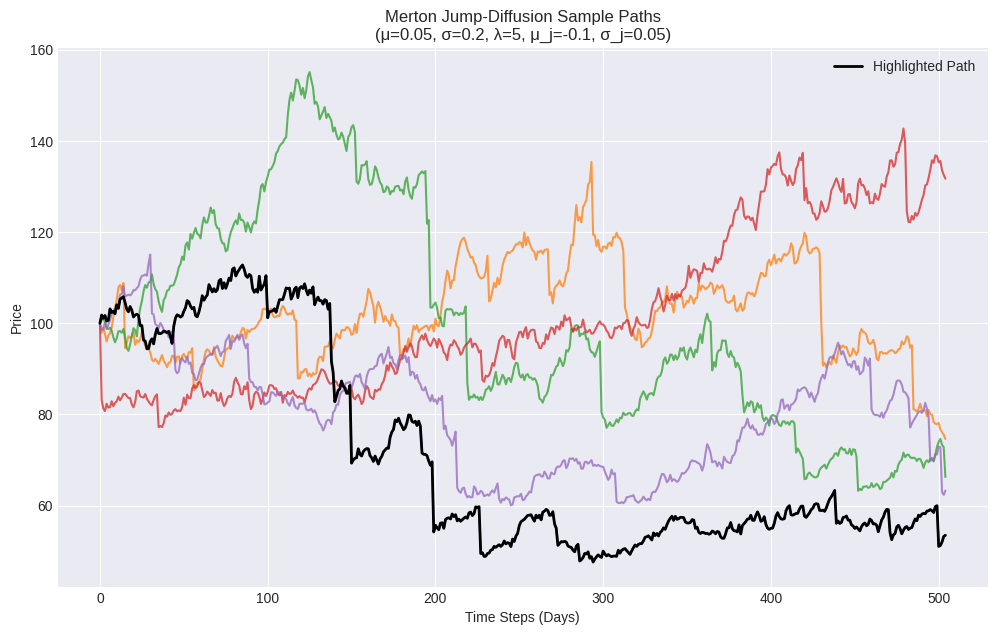

Running validation simulation...


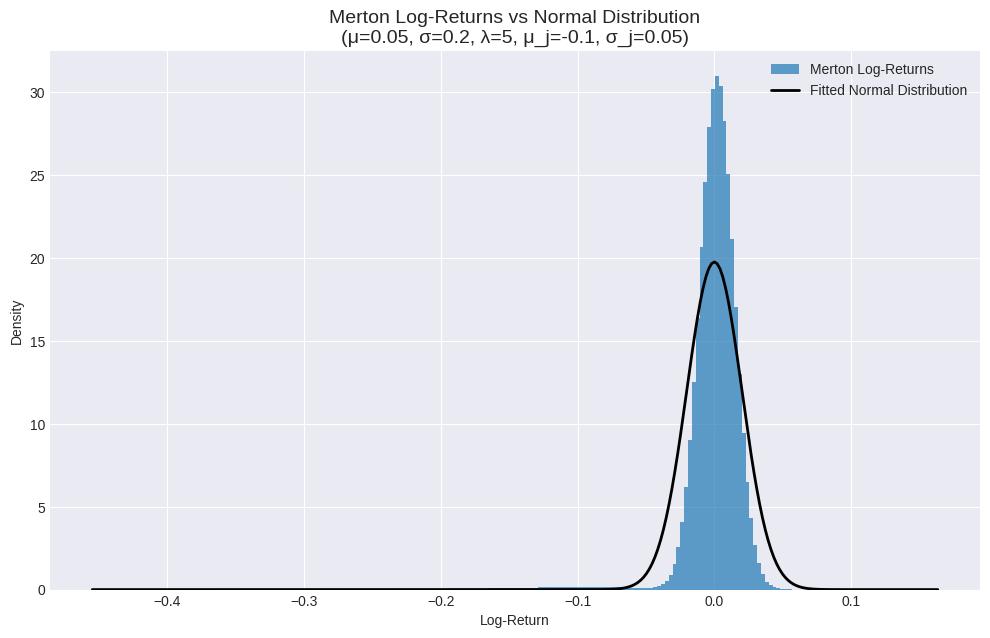

Excess Kurtosis: 32.1359
(Normal distribution has excess kurtosis = 0. More = heavier tails.)

===== Jump Frequency Validation =====
Empirical Jump Count   : 51537
Expected Jump Count    : 50000.00
Difference             : 1537.00

Interpretation:
- Empirical should be close to expected (±10–20%) for large n.
- If lower: jumps too small / threshold too strict.
- If higher: too many large moves -> tune σ_j or μ_j.


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from scipy import stats

sys.path.insert(0, os.path.abspath('../src'))
from models.merton import MertonJumpDiffusion

plt.style.use('seaborn-v0_8-darkgrid')
print("Setup complete.")

# ============================================================
# 1. CREATE MODEL
# ============================================================
merton_params = {
    'S0': 100,
    'mu': 0.05,         
    'sigma': 0.2,       
    'lambda_j': 5,      
    'mu_j': -0.1,      
    'sigma_j': 0.05     
}

merton_model = MertonJumpDiffusion(**merton_params)
print("Merton Jump-Diffusion Model Created:")
print(merton_model)

# ============================================================
# 2. SIMULATE PATHS (for visuals)
# ============================================================
T = 2.0
dt = 1/252
n_paths = 5

sim_paths = merton_model.simulate(T, dt, n_paths)

plt.figure(figsize=(12, 7))
plt.plot(sim_paths, alpha=0.75)
plt.plot(sim_paths[:, 0], color='black', linewidth=2, label="Highlighted Path")
plt.title(
    f"Merton Jump-Diffusion Sample Paths\n"
    f"(μ={merton_params['mu']}, σ={merton_params['sigma']}, "
    f"λ={merton_params['lambda_j']}, μ_j={merton_params['mu_j']}, σ_j={merton_params['sigma_j']})"
)
plt.xlabel("Time Steps (Days)")
plt.ylabel("Price")
plt.legend()
plt.show()

# ============================================================
# TOP VALIDATION 1: FAT-TAILED RETURNS (Histogram + Kurtosis)
# ============================================================

print("Running validation simulation...")

n_val_paths = 5000
val_paths = merton_model.simulate(T, dt, n_val_paths)

log_returns = np.log(val_paths[1:] / val_paths[:-1]).flatten()

# Histogram of returns
plt.figure(figsize=(12, 7))
plt.hist(log_returns, bins=200, density=True, alpha=0.7, label="Merton Log-Returns")

# Fit normal distribution
mu_fit, std_fit = stats.norm.fit(log_returns)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 300)
pdf_normal = stats.norm.pdf(x, mu_fit, std_fit)

plt.plot(x, pdf_normal, 'k', linewidth=2, label="Fitted Normal Distribution")

plt.title(
    f"Merton Log-Returns vs Normal Distribution\n"
    f"(μ={merton_params['mu']}, σ={merton_params['sigma']}, "
    f"λ={merton_params['lambda_j']}, μ_j={merton_params['mu_j']}, σ_j={merton_params['sigma_j']})",
    fontsize=14
)
plt.xlabel("Log-Return")
plt.ylabel("Density")
plt.legend()
plt.show()

# Excess kurtosis — key fat-tail indicator
kurtosis_val = stats.kurtosis(log_returns)
print(f"Excess Kurtosis: {kurtosis_val:.4f}")
print("(Normal distribution has excess kurtosis = 0. More = heavier tails.)\n")

# ============================================================
# TOP VALIDATION 2: CHECK JUMP FREQUENCY
# ============================================================

# Count jumps by detecting large sudden moves
# A simple approach: detect returns larger than 3 * daily diffusion std
diffusion_std = merton_params['sigma'] * np.sqrt(dt)
jump_threshold = 3 * diffusion_std  # anything bigger is likely a jump

# Identify where jumps occur (absolute returns > threshold)
jump_events = np.abs(log_returns) > jump_threshold
jump_count_empirical = np.sum(jump_events)

# Expected jumps:
expected_jumps = merton_params['lambda_j'] * T * n_val_paths

print("===== Jump Frequency Validation =====")
print(f"Empirical Jump Count   : {jump_count_empirical}")
print(f"Expected Jump Count    : {expected_jumps:.2f}")
print(f"Difference             : {jump_count_empirical - expected_jumps:.2f}")
print("\nInterpretation:")
print("- Empirical should be close to expected (±10–20%) for large n.")
print("- If lower: jumps too small / threshold too strict.")
print("- If higher: too many large moves -> tune σ_j or μ_j.")
